# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 
У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.stats.power import NormalIndPower
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [2]:
sessions_history=pd.read_csv('/datasets/sessions_project_history.csv')
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
sessions_per_user = sessions_history.groupby("user_id")["session_id"].nunique().reset_index()
sessions_per_user.columns = ["user_id", "unique_sessions"]
sessions_per_user


,user_id,unique_sessions
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2
...,...,...
134034,FFFCDE7746148710,4
134035,FFFDD413285E753F,3
134036,FFFECBA0F2578AB0,2
134037,FFFEDB68228B5F21,5


In [4]:
top_user_id = sessions_per_user.loc[sessions_per_user['unique_sessions'].idxmax(), 'user_id']
top_user_data = sessions_history[sessions_history['user_id'] == top_user_id]
display(top_user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [5]:
df_grp = (
    sessions_history.groupby(['session_date']).agg(
        {
        'user_id': 'nunique',
        'registration_flag':'sum'
    })
    .reset_index()
)

df_grp.columns=["date","amount_users","registr_users"]
df_grp

,date,amount_users,registr_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


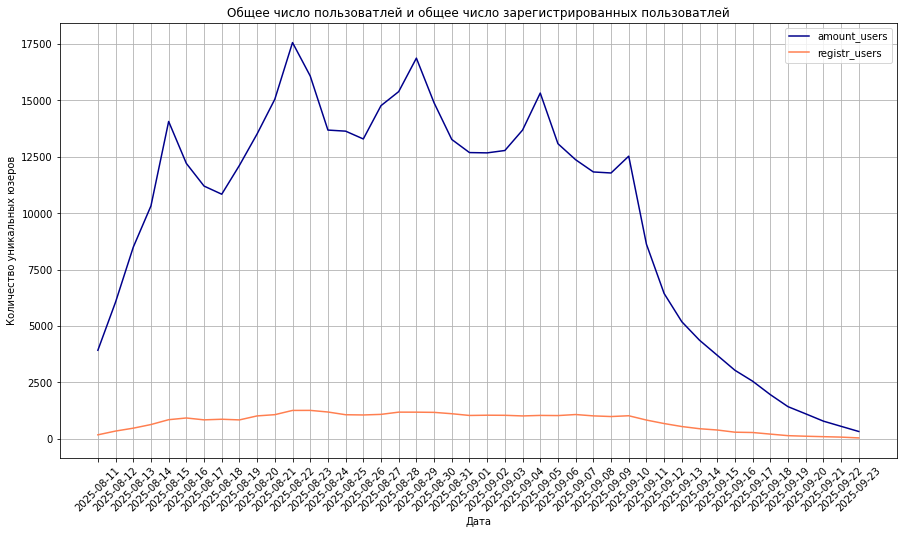

In [6]:
x = df_grp.date.unique()
y_a = df_grp['amount_users']
y_b = df_grp['registr_users']

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='amount_users', color='darkblue')
plt.plot(x, y_b,label ='registr_users', color='coral')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных юзеров")
plt.legend()
plt.title('Общее число пользоватлей и общее число зарегистрированных пользоватлей')
plt.xticks(rotation=45)
plt.grid()
plt.show()

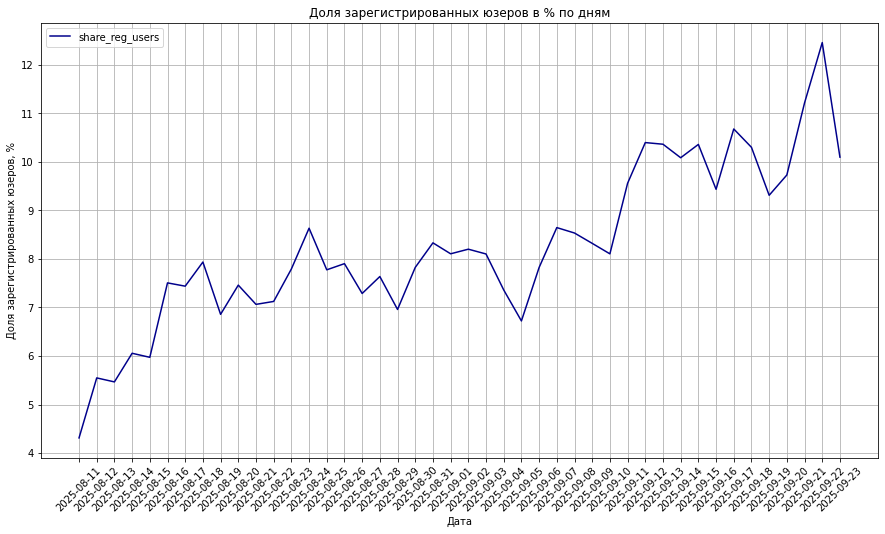

In [7]:
share_reg_users=df_grp['registr_users']/df_grp['amount_users']*100
x = df_grp.date.unique()
y = share_reg_users


plt.figure(figsize=(15, 8))
plt.plot(x, y,label='share_reg_users', color='darkblue')


plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных юзеров, %")
plt.legend()
plt.title('Доля зарегистрированных юзеров в % по дням')
plt.xticks(rotation=45)
plt.grid()
plt.show()

По графику видим, что доля зарегисnрированных юзеров за период наблюдения растет, начиная с 04.09.2025.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [8]:
sessions_per_page_counter = sessions_history.groupby("page_counter")["session_id"].nunique().reset_index()
sessions_per_page_counter.columns = ["page_counter", "unique_sessions"]
sessions_per_page_counter

,page_counter,unique_sessions
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


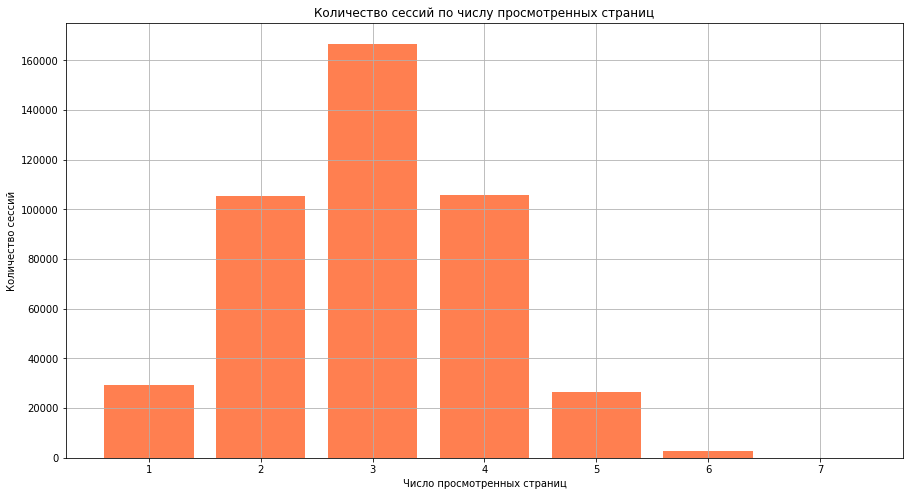

In [9]:
x = sessions_per_page_counter.page_counter
y = sessions_per_page_counter['unique_sessions']

plt.figure(figsize=(15, 8))
plt.bar(x, y,label ='', color='coral')

plt.xlabel("Число просмотренных страниц")
plt.ylabel("Количество сессий")
plt.title('Количество сессий по числу просмотренных страниц')

plt.grid()
plt.show()

За 1 сессию большая честь юзеров просматривает 3 страницы 

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [10]:
sessions_history['good_sessions'] = 0
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_sessions'] = 1
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_sessions
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [11]:
gr_by_date = (
    sessions_history.groupby(['session_date']).agg(
        {
        'session_id': 'nunique',
        'good_sessions':'sum'
    })
    .reset_index()
)

gr_by_date.columns=["date","amount_sessions","amount_good"]
gr_by_date

,date,amount_sessions,amount_good
0,2025-08-11,3919,1226
1,2025-08-12,6056,1829
2,2025-08-13,8489,2604
3,2025-08-14,10321,3262
4,2025-08-15,14065,4289
5,2025-08-16,12205,3737
6,2025-08-17,11200,3557
7,2025-08-18,10839,3366
8,2025-08-19,12118,3791
9,2025-08-20,13514,4148


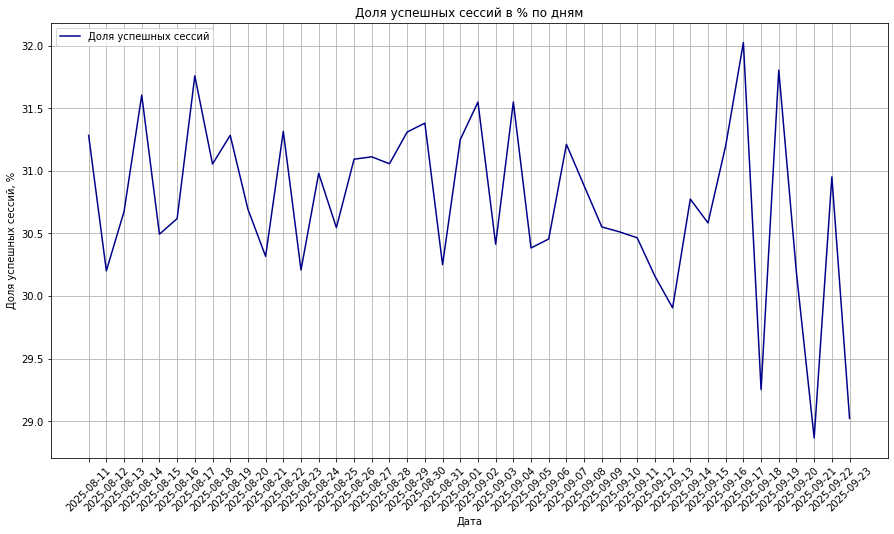

In [12]:
share_good_sessions=gr_by_date['amount_good']/gr_by_date['amount_sessions']*100
x = df_grp.date.unique()
y = share_good_sessions


plt.figure(figsize=(15, 8))
plt.plot(x, y,label='Доля успешных сессий', color='darkblue')


plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий, %")
plt.legend()
plt.title('Доля успешных сессий в % по дням')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [13]:

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [14]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(17441*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [15]:
sessions_test_part=pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [16]:
amount_a=sessions_test_part[(sessions_test_part['test_group']=='A') & (sessions_test_part['session_date']=='2025-10-14')]['user_id'].nunique()
amount_b=sessions_test_part[(sessions_test_part['test_group']=='B')& (sessions_test_part['session_date']=='2025-10-14')]['user_id'].nunique()
amount=sessions_test_part['user_id'].nunique()
print(amount_a, amount_b, amount)

1477 1466 2943


In [17]:

percent = round((amount_a-amount_b)/amount_a*100,2)
print(f"Процентная разница между группами составляет {percent}%")



Процентная разница между группами составляет 0.74%


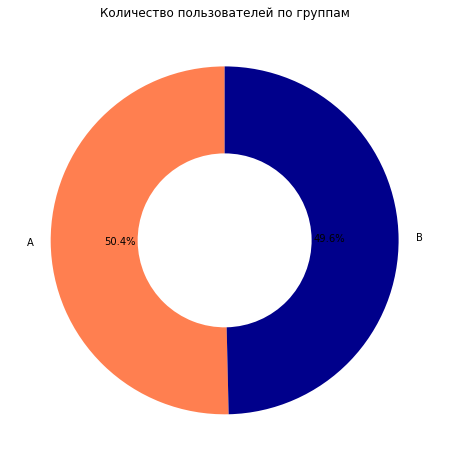

In [18]:
labels = ['A','B']
sizes = [amount+percent*amount/100, amount-percent*amount/100]
colors = ['coral','darkblue']


plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.5})


plt.title('Количество пользователей по группам')
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [19]:
a_users=sessions_test_part[sessions_test_part['test_group']=='A']['user_id']
b_users=sessions_test_part[sessions_test_part['test_group']=='B']['user_id']
intersection = list(set(a_users) & set(b_users))
print(F"Количество пользователей,которые встречаются одновременно в группах A и B - {len(intersection)}")

Количество пользователей,которые встречаются одновременно в группах A и B - 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [20]:
A=sessions_test_part[sessions_test_part['test_group']=='A']
B=sessions_test_part[sessions_test_part['test_group']=='B']

a_grp_device=A.groupby('device')['user_id'].nunique().reset_index()
a_grp_device.columns=['device', 'amount']
a_grp_device['share_amount']=round(a_grp_device['amount']/A['user_id'].nunique(),2)
a_grp_device

,device,amount,share_amount
0,Android,656,0.44
1,Mac,156,0.11
2,PC,369,0.25
3,iPhone,296,0.20


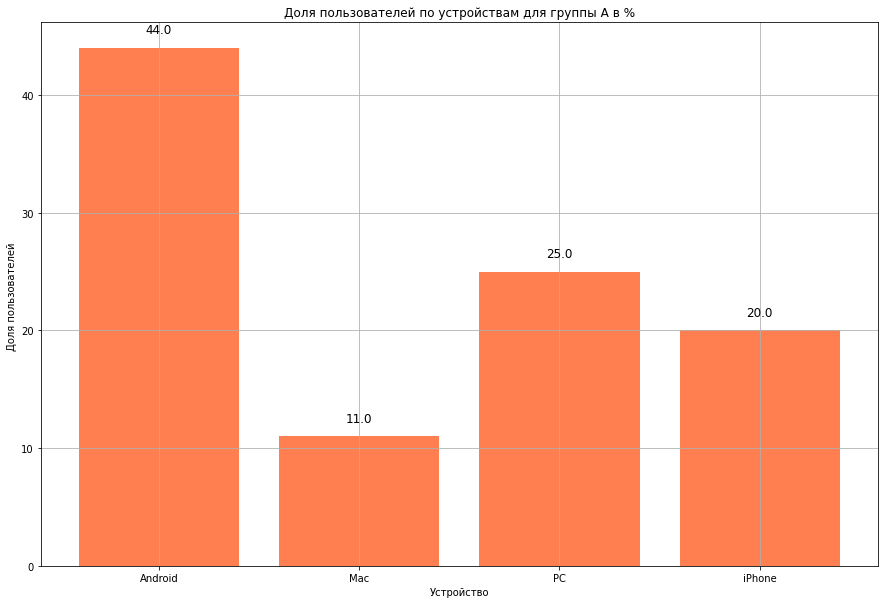

In [21]:
x = a_grp_device['device']
y = a_grp_device ['share_amount']*100

plt.figure(figsize=(15, 10))

plt.bar(x, y,label ='', color='coral')

for i, y in enumerate(y):
    plt.text(i, y + 1, str(y), ha='center', va='bottom', fontsize=12)


plt.xlabel("Устройство")
plt.ylabel("Доля пользователей ")

plt.title('Доля пользователей по устройствам для группы А в %')

plt.grid()
plt.show()

In [22]:
b_grp_device=B.groupby('device')['user_id'].nunique().reset_index()
b_grp_device.columns=['device', 'amount']
b_grp_device['share_amount']=round(b_grp_device['amount']/B['user_id'].nunique(),2)
b_grp_device

,device,amount,share_amount
0,Android,668,0.46
1,Mac,148,0.10
2,PC,381,0.26
3,iPhone,269,0.18


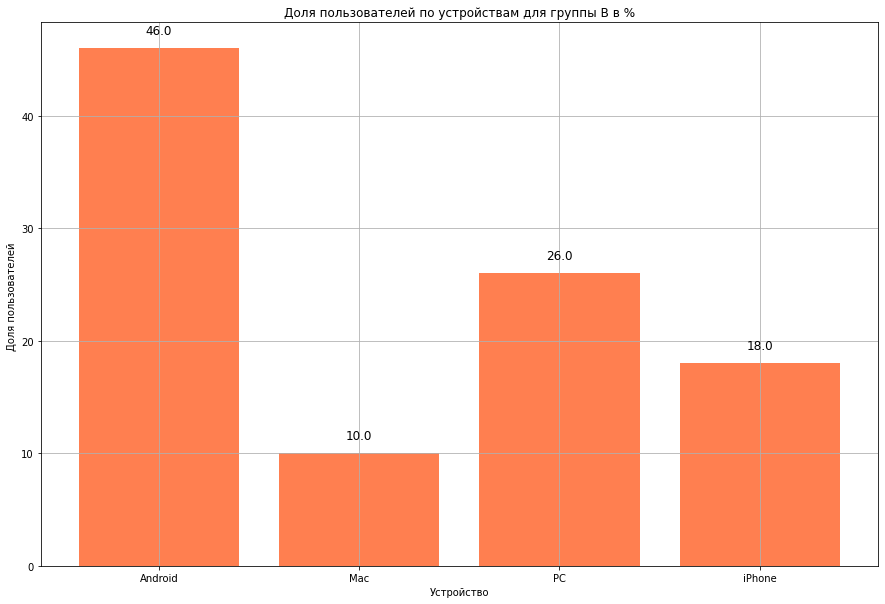

In [23]:
x = b_grp_device['device']
y = b_grp_device ['share_amount']*100

plt.figure(figsize=(15, 10))

plt.bar(x, y,label ='', color='coral')

for i, y in enumerate(y):
    plt.text(i, y + 1, str(y), ha='center', va='bottom', fontsize=12)


plt.xlabel("Устройство")
plt.ylabel("Доля пользователей ")
plt.title('Доля пользователей по устройствам для группы B в %')
plt.grid()
plt.show()

**Вывод:** пользователи по устройствам распределены равномерно.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [24]:
a_grp_region=A.groupby('region')['user_id'].nunique().reset_index()
a_grp_region.columns=['region', 'amount']
a_grp_region['share_amount']=round(a_grp_device['amount']/A['user_id'].nunique(),2)
a_grp_region

,region,amount,share_amount
0,CIS,644,0.44
1,EU,224,0.11
2,MENA,609,0.25


In [25]:
b_grp_region=B.groupby('region')['user_id'].nunique().reset_index()
b_grp_region.columns=['region', 'amount']
b_grp_region['share_amount']=round(a_grp_device['amount']/B['user_id'].nunique(),2)
b_grp_region

,region,amount,share_amount
0,CIS,645,0.45
1,EU,217,0.11
2,MENA,604,0.25


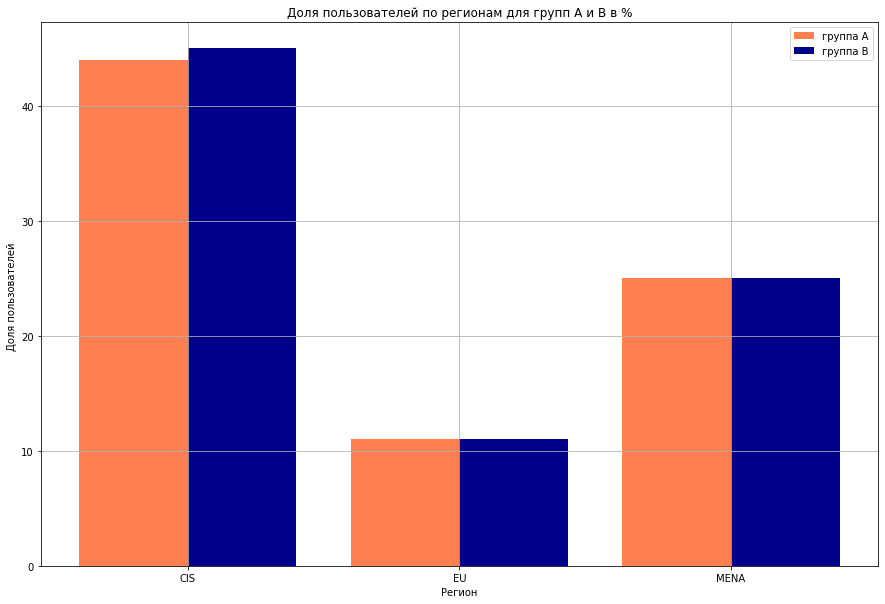

In [26]:
labels = b_grp_region['region']
x = np.arange(len(labels))
y_a = a_grp_region ['share_amount']*100
y_b = b_grp_region ['share_amount']*100
width=0.4
plt.figure(figsize=(15, 10))

plt.bar(x-width/2,y_a, width, label ='группа А', color='coral')
plt.bar(x+width/2,y_b, width, label ='группа B', color='darkblue')


plt.xlabel("Регион")
plt.xticks(x, labels)
plt.ylabel("Доля пользователей ")
plt.legend()
plt.title('Доля пользователей по регионам для групп A и B в %')

plt.grid()
plt.show()

Распределение пользоватлей по регионам в тестовой и контрольной группах практически не различается.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

   **На основе проведенного анализа можно заключить, что:**
1. Процентная разница между группами составляет 0,74%, что не критично.
2. Пересечения между тестовой и контрольной группой не было обнаружено.
3. Распределение пользователей тестовой и контрольной группами
 - по усройствам: колеблется не более чем на на 2%
 - по регионам: колеблется не более чем на 1%
 
 Тест проходит корректно.
 

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [27]:
sessions_test=pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [28]:
sessions_test['good_sessions']=0
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_sessions'] = 1
sessions_test.head(20)        

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_sessions
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1
7,457F2674E87EF6E7,14F71C18BE2CEC08,2025-10-19,2025-10-19 11:49:11,2025-10-19,1,0,3,MENA,Mac,A,0
8,57F342451921D207,76EFA055599ADE3C,2025-10-19,2025-10-19 18:47:43,2025-10-19,1,0,3,CIS,PC,A,0
9,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [29]:
A=sessions_test[sessions_test['test_group']=='A']
B=sessions_test[sessions_test['test_group']=='B']
grp_a_by_date=A.groupby('session_date')['session_id'].nunique().reset_index()
grp_a_by_date.columns=['session_date','amount_a']
grp_b_by_date=B.groupby('session_date')['session_id'].nunique().reset_index()
grp_b_by_date.columns=['session_date','amount_b']
sessions_by_date = pd.merge(grp_a_by_date, grp_b_by_date, on='session_date', how='outer')
display(sessions_by_date)


,session_date,amount_a,amount_b
0,2025-10-14,1502,1628
1,2025-10-15,2235,2283
2,2025-10-16,3280,3241
3,2025-10-17,4089,4054
4,2025-10-18,5013,5059
5,2025-10-19,6535,6779
6,2025-10-20,5837,6089
7,2025-10-21,3927,3981
8,2025-10-22,3083,3111
9,2025-10-23,2470,2548


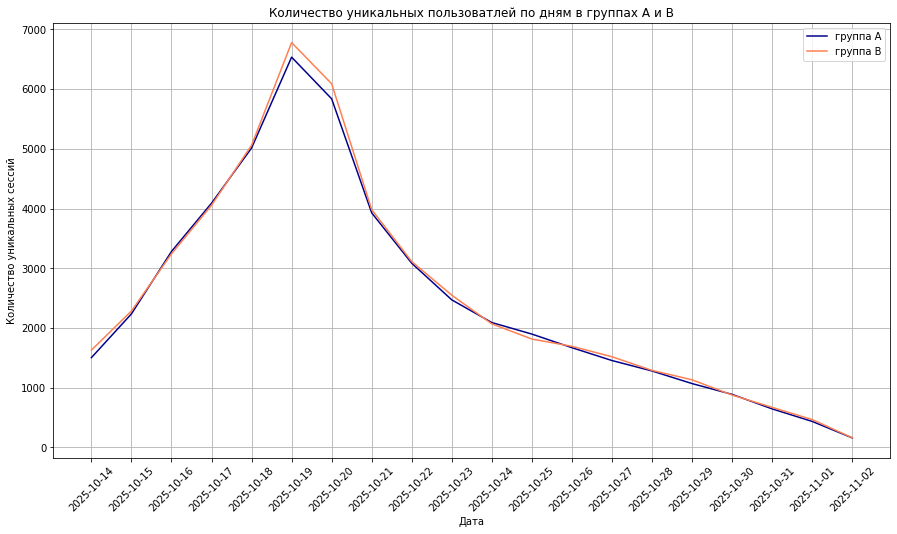

In [30]:
x = sessions_by_date['session_date']
y_a = sessions_by_date['amount_a']
y_b = sessions_by_date['amount_b']

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='группа А', color='darkblue')
plt.plot(x, y_b,label ='группа B', color='coral')


plt.xlabel("Дата")
plt.ylabel("Количество уникальных сессий")
plt.legend()
plt.title('Количество уникальных пользоватлей по дням в группах A и B')
plt.xticks(rotation=45)
plt.grid()
plt.show()

По графику и расчету видим, что количество пользователей по дням в группах не раздличаются, проверим статистическую значимость этй гипотезы. 
**Формулировка гипотезы**

H₀ (нулевая гипотеза) — количество уникальных дневных сессий `не различается` между тестовой и контрольной группами.

H₁ (альтернативная гипотеза) — количество уникальных дневных сессий `различается` между тестовой и контрольной группами.

In [31]:

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    sessions_by_date['amount_a'], 
    sessions_by_date['amount_b'], 
    alternative='two-sided' 
) 

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    

p-value теста Стьюдента =0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [32]:
a_group=sessions_test[sessions_test['test_group']=='A']
b_group=sessions_test[sessions_test['test_group']=='B']
a_group.head(20)
b_group.head(20)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_sessions
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1
9,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B,0
10,E3D2FC1168EB2558,B585AABE5484C3D1,2025-10-19,2025-10-19 13:13:23,2025-10-16,3,0,3,MENA,Android,B,0
11,2E1AE08A3A687FC4,2B186C8BF8DA8AE7,2025-10-17,2025-10-17 12:41:17,2025-10-15,2,0,3,CIS,iPhone,B,0
12,9E808F04A69C9D34,D4C3B30B00F5DE94,2025-10-20,2025-10-20 18:45:59,2025-10-18,2,0,4,CIS,PC,B,1
19,99C08B471B90B14F,85D67806A17E00A4,2025-10-24,2025-10-24 18:52:23,2025-10-19,3,0,2,MENA,iPhone,B,0


In [33]:
share_good_sessions_a=round(a_group['good_sessions'].sum()/a_group['session_id'].count()*100,2)
share_good_sessions_b=round(b_group['good_sessions'].sum()/b_group['session_id'].count()*100,2)
print(f'Доля успешных сессий в группе A: {share_good_sessions_a}%, в группе B:{share_good_sessions_b}%')

Доля успешных сессий в группе A: 30.77%, в группе B:31.83%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

**Формулировка гипотезы**

H₀ (нулевая гипотеза) — доля успешных сессий  в тестовой группе (В) не отличается от доли успешных сессий в контрольной группе (А).

H₁ (альтернативная гипотеза) — доля успешных сесий в тестовой группе выше чем в контрольной группе.

In [34]:
#считаем размеры выборок
n_a=a_group.shape[0]
n_b=b_group.shape[0]
n_a, n_b

(49551, 50454)

In [35]:
#считаем количество успехов
m_a=a_group['good_sessions'].sum()
m_b=b_group['good_sessions'].sum()
m_a,m_b

(np.int64(15248), np.int64(16059))

In [36]:
#проверяем стат значимость гиоптезы: доля успехов в тестовой выборке больше доли успехов в исходной выборке
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.


# 📊 A/B Тест: Анализ доли успешных сессий

## Цель
Проверить, повлияло ли изменение алгоритма рекомендаций на **долю успешных сессий** у пользователей приложения.

---

##  Данные
- **Группы**: A (контрольная) и B (тестовая) по 17441 пользователя в каждой
- **Период теста**: 01.10.2025 – 14.10.2025: 4 дня
- **Метрика**: доля успешных сессий, где успешные — сессии, где page_counter >= 4

---

##  Методы
- Был проведен расчет доли успешных сессий по группам
- Была проведена оценка статистической значимости различий между группами проводилась с помощью  z-теста для пропорций 

---

## Результаты

**Доля успешных сессий:**

| Группа | Успешные сессии | Всего сессий | Доля |
|--------|------------------|---------------|-------|
| **A**  | 15248              | 49551          | 30.77% |
| **B**  | 16059              | 50454          |31.83%  |

---

##  Статистический тест


В результате проведенного z-теста pvalue=0.0001574739988036123 < 0.05, то есть можно считать результат статистичеси значимым.


## Рекомендации

Так как в группе B наблюдается рост доли успешных сессий на 1,1% по сравнению с группой А, и результат является статистически значимым, но MDE — 3%, не могу пока рекомендовать внедрение нового алгоритма. Можно провести повторный более чувствительный тест, если нужно.
